In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from pmdarima.arima import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from datetime import datetime
import folium

In [2]:
confirmed_cases_path = os.path.join(os.getcwd(),"covid19_confirmed_global.txt")
deaths_path = os.path.join(os.getcwd(),"covid19_deaths_global.txt")

In [3]:
confirmed_cases = pd.read_csv(confirmed_cases_path)
deaths = pd.read_csv(deaths_path)

In [4]:
confirmed_cases

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21,11/26/21,11/27/21,11/28/21,11/29/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,156864,156896,156911,157015,157032,157144,157171,157190,157218,157260
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,195988,195988,196611,197167,197776,198292,198732,199137,199555,199750
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,208839,208952,209111,209283,209463,209624,209817,209980,210152,210344
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,16086,16086,16299,16342,16426,16566,16712,16712,16712,16712
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,65011,65024,65033,65061,65080,65105,65130,65139,65144,65155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,...,1084625,1094514,1104835,1143967,1155778,1168228,1181337,1197404,1210340,1224110
276,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,457950,457950,458448,458698,458956,459213,459479,459479,459479,460053
277,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,9955,9955,9961,9967,9972,9977,9979,9981,9987,9995
278,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,210057,210070,210073,210090,210099,210112,210118,210138,210143,210150


In [5]:
#cases in th US
usconfirmed = confirmed_cases.loc[confirmed_cases["Country/Region"] == "US"]
usconfirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21,11/26/21,11/27/21,11/28/21,11/29/21
255,NaN,US,40.0,-100.0,1,1,2,2,5,5,...,47700783,47738554,47889042,47981453,48092823,48125425,48176523,48201079,48229210,48437955


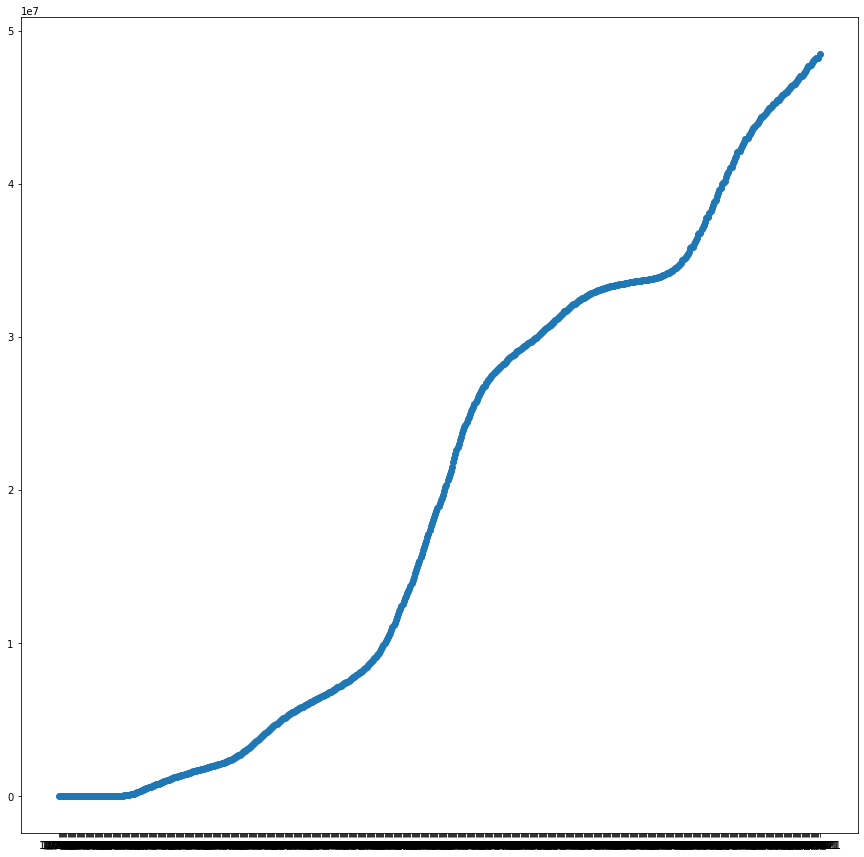

In [6]:
fig,ax = plt.subplots(1,1,figsize = (15,15))
ax.plot_date(usconfirmed.columns.tolist()[4:],list(usconfirmed[usconfirmed.columns.tolist()[4:]].iloc[0,:]))

In [7]:
#creating a test set and testing set for predicting the data
#80% will be used for the training and 20% will be used for testing
dates = confirmed_cases.loc[confirmed_cases["Country/Region"] == "US"].columns.tolist()[4:]

In [8]:
training_dates = dates[:int(np.floor(len(dates)*0.8))]
testing_dates = dates[int(np.floor(len(dates)*0.8))-1:]

<h3> As this involves time series forecasting, first I will investigate the Auto Regressive Intergrated Moving Average(ARIMA) model </h3>

- As the ARIMA model required 3 inputs (p,d,q) , 1) The order of lags(amount of past data to use for prediction), 2) The number of times the past data needs to be substracted from previous values 3) the order of the moving average model, I will investigate different values of p,d,q and find the one which gives least RMSE

In [9]:
training_dataset = usconfirmed[training_dates].diff(axis = 1)
testing_dataset = usconfirmed[testing_dates].diff(axis = 1)

In [10]:
training_dataset

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,7/7/21,7/8/21,7/9/21,7/10/21,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21
255,NaN,0,1,0,3,0,0,1,0,2,...,22634,19029,47489,8420,11153,33615,26392,33170,29907,77479


In [11]:
testing_dataset

,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21,7/21/21,7/22/21,7/23/21,7/24/21,7/25/21,...,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21,11/26/21,11/27/21,11/28/21,11/29/21
255,NaN,11886,19975,52121,40572,50586,54666,119396,25180,25634,...,41493,37771,150488,92411,111370,32602,51098,24556,28131,208745


In [12]:
training_dataset = training_dataset.iloc[:,1:]
testing_dataset = testing_dataset.iloc[:,1:]

In [13]:
#finding optimal ranges for differency order of ARIMA model 
#Differencing is used to make the time series stationary
#A proper order of differencing is the minimum differencing required to get a near 
#stationary series

#Use Augmented Dicky Fuller test to test for stationarity
#If p value is greater than 0.05, the series is non stationary

result = adfuller(training_dataset.to_numpy().reshape(-1,))
print('p-value: %f' % result[1])

p-value: 0.391276


Series is non stationary

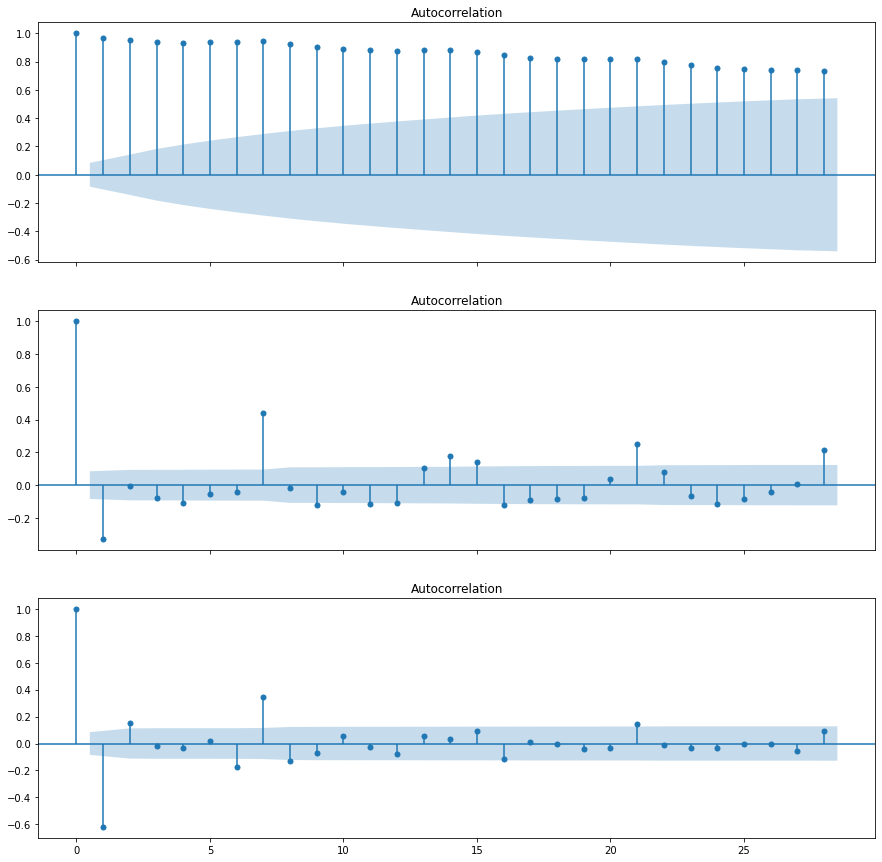

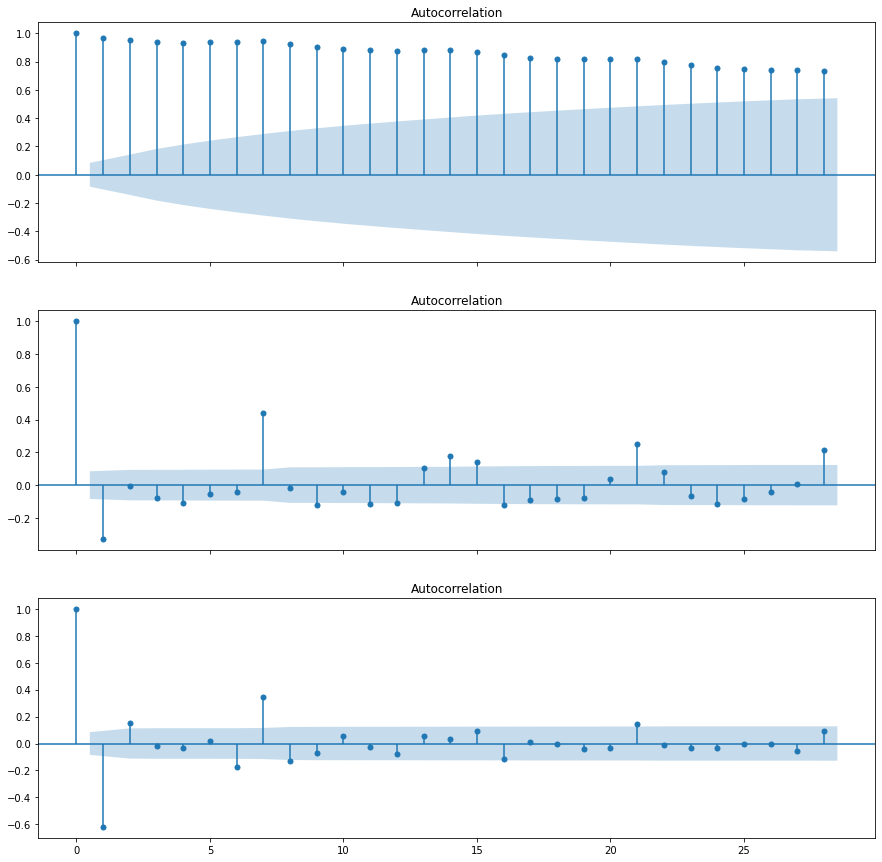

In [14]:
#using auto correlation to identify the order of differencing
fig, axes = plt.subplots(3, 1, sharex=True,figsize = (15,15))
plot_acf(training_dataset.to_numpy().reshape(-1,),ax = axes[0])
plot_acf(training_dataset.diff(axis=1).iloc[0,1:].to_numpy().reshape(-1,),ax = axes[1])
plot_acf(training_dataset.diff(axis=1).diff(axis=1).iloc[0,2:].to_numpy().reshape(-1,),ax = axes[2])

Looking at the above plots, the autocorrelation plot for the 2nd order of differencing reaches into the negative values very quickly, indicating that the series is over differenced. Hence one order of differencing is selected.

Finding the number of lags to use

To do this we use partial auto correlation. 

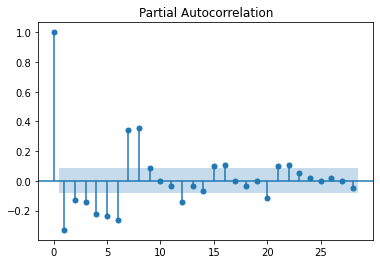

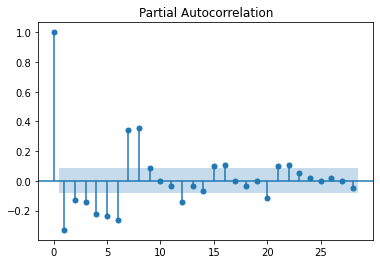

In [15]:
plot_pacf(training_dataset.diff(axis = 1).iloc[0,1:])

Strongest partial correlation exists with 1 lag.

Selecting the order for Moving average

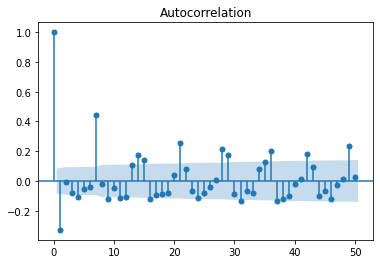

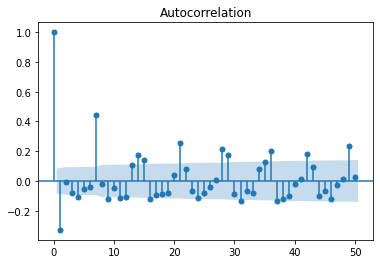

In [16]:
plot_acf(training_dataset.diff(axis=1).iloc[0,1:].to_numpy().reshape(-1,),lags = 50)

A q value of 1 will be investigated

In [17]:
#to select the range of p,d,q values, I have taken reference from Aggarwal et al.
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8138040/pdf/main.pdf
p = [1]
d = [1]
q = [1]
combinations = list(product([i for i,j in enumerate(p)],[i for i,j in enumerate(d)],[i for i,j in enumerate(q)]))
parameter_list = list()
#format of parameters:
#no_of_estimators,criterion,max_features
for combination in combinations:
    parameter_list.append([p[combination[0]],d[combination[1]],q[combination[2]]])


In [18]:
parameter_predictions = list()
rmse_list = list()

for parameters in parameter_list:
    estim_arima = ARIMA(order = (parameters[0],parameters[1],parameters[2]),suppress_warnings=True)
    #fit on entire training set
    estim_arima.fit(training_dataset.to_numpy().reshape(-1,))
    #predict for n_periods equal to size of validation set
    predictions = estim_arima.predict(n_periods=testing_dataset.shape[1])
    rmse = np.sqrt(mean_squared_error(testing_dataset.to_numpy().reshape(-1,), predictions))
    parameter_predictions.append((parameters,predictions))
    rmse_list.append((parameters,rmse))

In [19]:
rmse_list

[([1, 1, 1], 77579.17641720877)]

In [20]:
#to select the range of p,d,q values, I have taken reference from Aggarwal et al.
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8138040/pdf/main.pdf
p = [1,2,3,4,5,6,7]
d = [1,2,3]
q = [1,2]
combinations = list(product([i for i,j in enumerate(p)],[i for i,j in enumerate(d)],[i for i,j in enumerate(q)]))
parameter_list = list()
#format of parameters:
#no_of_estimators,criterion,max_features
for combination in combinations:
    parameter_list.append([p[combination[0]],d[combination[1]],q[combination[2]]])


In [21]:
parameter_predictions = list()
rmse_list = list()

for parameters in parameter_list:
    estim_arima = ARIMA(order = (parameters[0],parameters[1],parameters[2]),suppress_warnings=True)
    #fit on entire training set
    estim_arima.fit(training_dataset.to_numpy().reshape(-1,))
    #predict for n_periods equal to size of validation set
    predictions = estim_arima.predict(n_periods=testing_dataset.shape[1])
    rmse = np.sqrt(mean_squared_error(testing_dataset.to_numpy().reshape(-1,), predictions))
    parameter_predictions.append((parameters,predictions))
    rmse_list.append((parameters,rmse))

In [22]:
sorted(rmse_list,key = lambda x: x[1])

[([7, 1, 1], 70190.86014335275),
 ([7, 1, 2], 72302.46107656149),
 ([4, 2, 1], 72940.7361745747),
 ([3, 1, 2], 74951.40150592859),
 ([1, 1, 2], 76443.48867297466),
 ([2, 1, 1], 77405.12083240882),
 ([1, 1, 1], 77579.17641720877),
 ([2, 1, 2], 77687.08691229885),
 ([4, 1, 2], 78847.87490209147),
 ([3, 1, 1], 79631.06368302356),
 ([5, 1, 2], 80772.54501620923),
 ([4, 1, 1], 81607.99438783395),
 ([5, 1, 1], 84199.36733771343),
 ([1, 2, 1], 85100.18783502847),
 ([2, 2, 1], 85378.23126376905),
 ([2, 2, 2], 86927.48792975387),
 ([6, 1, 2], 87224.05270337495),
 ([6, 1, 1], 88100.98482313282),
 ([3, 2, 1], 93911.4525504159),
 ([3, 2, 2], 96102.32204300283),
 ([1, 2, 2], 138089.48393808192),
 ([4, 2, 2], 226329.70970939696),
 ([6, 2, 1], 309504.22615816805),
 ([5, 2, 1], 312529.3877614852),
 ([7, 2, 1], 320102.37569308974),
 ([7, 2, 2], 323405.5748810824),
 ([6, 2, 2], 363634.2837560687),
 ([5, 2, 2], 527035.5375125079),
 ([5, 3, 2], 812801.5184154308),
 ([6, 3, 2], 816836.558652804),
 ([7, 3, 

The best set of Parameters are with a lag of 7 and differencing order and moving average lag of 1 respectively. 

In [23]:
#final ARIMA model for predicting confirmed cases will contain p,d,q=(1,1,3)
estim_arima_final = ARIMA(order = (7,1,1),suppress_warnings=True)
#fit on entire training set
estim_arima_final.fit(training_dataset.to_numpy().reshape(-1,))
#predict for n_periods equal to size of validation set
#7 extra days of prediction from 30 Nov 2021 to 6 Dec 2021.
predictions_final = np.floor(estim_arima_final.predict(n_periods=testing_dataset.shape[1] + 7)[-7:])
#rmse = np.sqrt(mean_squared_error(testing_dataset.to_numpy().reshape(-1,), predictions))

In [24]:
predictions_final

array([106465., 106797., 107127., 107454., 107777., 108099., 108423.])

The same approach is taken to predict the daily number of deaths

In [25]:
deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21,11/26/21,11/27/21,11/28/21,11/29/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,7363,7365,7365,7305,7306,7307,7307,7308,7308,7308
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3035,3035,3049,3053,3063,3068,3077,3085,3089,3092
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,6017,6021,6026,6030,6035,6041,6046,6052,6058,6064
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,130,130,130,130,131,131,131,131,131,131
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1730,1730,1730,1730,1731,1732,1733,1733,1733,1733


In [26]:
usdeaths = deaths.loc[deaths["Country/Region"] == "US"]
usdeaths

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21,11/26/21,11/27/21,11/28/21,11/29/21
255,NaN,US,40.0,-100.0,0,0,0,0,0,0,...,771417,771530,772762,774062,775724,776090,776349,776536,776639,778601


In [27]:
training_dates = dates[:int(np.floor(len(dates)*0.8))]
#an extra date kept at beginning for differencing purposes
testing_dates = dates[int(np.floor(len(dates)*0.8))-1:]
training_dataset_deaths = usdeaths[training_dates].diff(axis = 1)
testing_dataset_deaths = usdeaths[testing_dates].diff(axis = 1)

In [28]:
training_dataset_deaths = training_dataset_deaths.iloc[:,1:]
testing_dataset_deaths = testing_dataset_deaths.iloc[:,1:]

In [29]:
testing_dataset_deaths

,7/17/21,7/18/21,7/19/21,7/20/21,7/21/21,7/22/21,7/23/21,7/24/21,7/25/21,7/26/21,...,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21,11/26/21,11/27/21,11/28/21,11/29/21
255,67,173,200,292,352,294,560,119,85,265,...,333,113,1232,1300,1662,366,259,187,103,1962


In [30]:
#checking whether the deaths dataset is non stationary
result_deaths = adfuller(training_dataset_deaths.to_numpy().reshape(-1,))
print('p-value: %f' % result_deaths[1])

p-value: 0.174991


With a p values greater than 0.05, it is non stationary

In [31]:
#to select the range of p,d,q values, I have taken reference from Aggarwal et al.
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8138040/pdf/main.pdf
p = [1,2,3,4,5,6,7]
d = [1,2,3]
q = [1,2]
combinations = list(product([i for i,j in enumerate(p)],[i for i,j in enumerate(d)],[i for i,j in enumerate(q)]))
parameter_list = list()
#format of parameters:
#no_of_estimators,criterion,max_features
for combination in combinations:
    parameter_list.append([p[combination[0]],d[combination[1]],q[combination[2]]])

In [32]:
parameter_predictions_deaths = list()
rmse_list_deaths = list()

for parameters in parameter_list:
    estim_arima_death = ARIMA(order = (parameters[0],parameters[1],parameters[2]),suppress_warnings=True)
    #fit on entire training set
    estim_arima_death.fit(training_dataset_deaths.to_numpy().reshape(-1,))
    #predict for n_periods equal to size of validation set
    predictions_deaths = estim_arima_death.predict(n_periods=testing_dataset_deaths.shape[1])
    rmse = np.sqrt(mean_squared_error(testing_dataset_deaths.to_numpy().reshape(-1,), predictions_deaths))
    parameter_predictions_deaths.append((parameters,predictions_deaths))
    rmse_list_deaths.append((parameters,rmse))

In [33]:
#least RMSE is obtained with p = 1,d = 1 and q = 2
sorted(rmse_list_deaths,key = lambda x:x[1])

[([1, 1, 2], 879.7122537600335),
 ([6, 2, 1], 1018.1692797636788),
 ([6, 2, 2], 1022.6679262147975),
 ([7, 2, 1], 1056.106685759442),
 ([2, 2, 2], 1060.4570683156155),
 ([2, 3, 1], 1073.0567378304142),
 ([3, 2, 2], 1092.6577416644625),
 ([7, 3, 1], 1157.2750869332674),
 ([7, 1, 1], 1199.2074435911584),
 ([7, 1, 2], 1229.2213784304345),
 ([4, 1, 2], 1238.8512648504943),
 ([2, 1, 2], 1270.155121811072),
 ([5, 1, 2], 1276.4586759940237),
 ([1, 1, 1], 1286.9465373943951),
 ([3, 1, 1], 1287.6071933844157),
 ([2, 1, 1], 1287.9596437296937),
 ([6, 1, 2], 1294.2471324666453),
 ([5, 1, 1], 1296.020430837482),
 ([6, 1, 1], 1308.869061981314),
 ([4, 1, 1], 1320.1363005350063),
 ([7, 2, 2], 1406.9871986916519),
 ([7, 3, 2], 1415.1020145121315),
 ([5, 2, 1], 1508.0974437807904),
 ([3, 1, 2], 1510.0961745776976),
 ([3, 3, 2], 1725.4963511039216),
 ([3, 3, 1], 1769.8875833187356),
 ([5, 3, 2], 1833.1256379033712),
 ([6, 3, 2], 1942.3553804676885),
 ([1, 2, 1], 2016.4853903272633),
 ([1, 2, 2], 2021.7

In [34]:
#final ARIMA model for predicting confirmed cases will contain p,d,q=(1,1,2)
estim_arima_final_deaths = ARIMA(order = (1,1,2),suppress_warnings=True)
#fit on entire training set
estim_arima_final_deaths.fit(training_dataset_deaths.to_numpy().reshape(-1,))
#predict for n_periods equal to size of validation set
#7 extra days of prediction from 30 Nov 2021 to 6 Dec 2021.
predictions_final_deaths = np.floor(estim_arima_final_deaths.predict(n_periods=testing_dataset_deaths.shape[1] + 7)[-7:])
#rmse = np.sqrt(mean_squared_error(testing_dataset.to_numpy().reshape(-1,), predictions))

In [35]:
predictions_final_deaths

array([1489., 1490., 1491., 1492., 1493., 1494., 1495.])

<h2> Trying to combine a Regressor with the prediction </h2>

In [36]:
regset = testing_dataset_deaths.iloc[:,:int(testing_dataset_deaths.shape[1]*0.5)]
valset = testing_dataset_deaths.iloc[:,int(testing_dataset_deaths.shape[1]*0.5):]

In [37]:
parameter_predictions_deaths = list()
rmse_list_deaths = list()

for parameters in parameter_list:
    estim_arima_death = ARIMA(order = (parameters[0],parameters[1],parameters[2]),suppress_warnings=True)
    #fit on entire training set
    estim_arima_death.fit(training_dataset_deaths.to_numpy().reshape(-1,))
    #predict for n_periods equal to size of validation set
    predictions_deaths = estim_arima_death.predict(n_periods=testing_dataset_deaths.shape[1])
    predictions_death_reg = predictions_deaths[:regset.shape[1]]
    predictions_deaths_val = predictions_deaths[regset.shape[1]:]
    gbrt = GradientBoostingRegressor(random_state=0,n_estimators=10)
    gbrt.fit(predictions_death_reg.reshape(-1,1),regset.to_numpy().reshape(-1,))
    predictions = gbrt.predict(predictions_deaths_val.reshape(-1,1))
    rmse = np.sqrt(mean_squared_error(valset.to_numpy().reshape(-1,), predictions))
    parameter_predictions_deaths.append((parameters,predictions))
    rmse_list_deaths.append((parameters,rmse))

In [38]:
sorted(rmse_list_deaths,key = lambda x:x[1])

[([6, 1, 1], 837.4667085152428),
 ([4, 1, 1], 845.6461185502624),
 ([6, 1, 2], 881.7171521398444),
 ([5, 3, 2], 928.5253641156314),
 ([5, 2, 1], 933.0709701025423),
 ([3, 1, 2], 963.3640132630024),
 ([6, 3, 2], 966.2444277866003),
 ([7, 2, 2], 966.5496104655),
 ([7, 3, 2], 976.1124680527014),
 ([3, 1, 1], 983.1932078750066),
 ([3, 3, 2], 983.1941439963423),
 ([1, 2, 1], 983.1941440178634),
 ([1, 2, 2], 983.1941440178634),
 ([2, 2, 1], 983.1941440178634),
 ([2, 3, 2], 983.1941440178634),
 ([3, 2, 1], 983.1941440178634),
 ([4, 2, 1], 983.1941440178634),
 ([4, 2, 2], 983.1941440178634),
 ([1, 1, 2], 983.1941440178636),
 ([1, 3, 1], 983.1941440178636),
 ([1, 3, 2], 983.1941440178636),
 ([2, 2, 2], 983.1941440178636),
 ([2, 3, 1], 983.1941440178636),
 ([3, 3, 1], 983.1941440178636),
 ([4, 3, 1], 983.1941440178636),
 ([4, 3, 2], 983.1941440178636),
 ([5, 3, 1], 983.1941440178636),
 ([3, 2, 2], 983.1941448939159),
 ([6, 3, 1], 983.194144928091),
 ([5, 2, 2], 996.4732471103631),
 ([5, 1, 2], 1

<h2>Task 2</h2>

In [39]:
columns = confirmed_cases.columns.tolist()

In [40]:
def turn_columns_to_datetime(x):
    try:
        return datetime.strptime(x,"%m/%d/%y")
    except:
        return x

In [41]:
datetime_adjusted = list(map(lambda x:turn_columns_to_datetime(x),columns))

In [42]:
indices_with_october_21 = list()

for i in range(len(datetime_adjusted)):
    try:
        if ((datetime_adjusted[i].month == 10) & (datetime_adjusted[i].year == 2021)):
            indices_with_october_21.append(i)
    except:
        continue

In [43]:
october_cases = confirmed_cases.iloc[:,[0,1,2,3] + [indices_with_october_21[0] - 1] + indices_with_october_21]
october_cases

,Province/State,Country/Region,Lat,Long,9/30/21,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,...,10/22/21,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21
0,NaN,Afghanistan,33.939110,67.709953,155174,155191,155191,155191,155287,155309,...,155931,155940,155944,156040,156071,156124,156166,156196,156210,156250
1,NaN,Albania,41.153300,20.168300,170131,170778,171327,171794,171794,172618,...,180623,181252,181696,181960,182610,183282,183873,184340,184887,185300
2,NaN,Algeria,28.033900,1.659600,203359,203517,203657,203789,203915,204046,...,205683,205750,205822,205903,205990,206069,206160,206270,206358,206452
3,NaN,Andorra,42.506300,1.521800,15222,15222,15222,15222,15267,15271,...,15404,15404,15404,15425,15425,15462,15505,15516,15516,15516
4,NaN,Angola,-11.202700,17.873900,56583,58076,58603,58943,58943,59895,...,63691,63775,63861,63930,64033,64126,64226,64301,64374,64433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,NaN,Vietnam,14.058324,108.277199,790755,797712,803202,808578,813961,818324,...,881522,884895,888940,892579,896174,900585,905477,910376,915603,921122
276,NaN,West Bank and Gaza,31.952200,35.233200,403716,405056,405780,406652,408211,409489,...,450310,450310,450310,451459,451897,452272,452642,452997,452997,452997
277,NaN,Yemen,15.552727,48.516388,9067,9111,9139,9139,9214,9234,...,9650,9662,9678,9694,9711,9728,9751,9773,9779,9791
278,NaN,Zambia,-13.133897,27.849332,209046,209114,209142,209163,209172,209199,...,209610,209629,209634,209639,209648,209657,209672,209702,209722,209734


In [44]:
#to calculate total cases in october only, we need to sum up all the daily new cases of October
october_daily_cases = pd.concat((october_cases.iloc[:,:4],october_cases.iloc[:,4:].diff(axis = 1).iloc[:,1:]),axis = 1)
october_daily_cases

,Province/State,Country/Region,Lat,Long,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,10/6/21,...,10/22/21,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21
0,NaN,Afghanistan,33.939110,67.709953,17,0,0,96,22,71,...,40,9,4,96,31,53,42,30,14,40
1,NaN,Albania,41.153300,20.168300,647,549,467,0,824,572,...,594,629,444,264,650,672,591,467,547,413
2,NaN,Algeria,28.033900,1.659600,158,140,132,126,131,125,...,84,67,72,81,87,79,91,110,88,94
3,NaN,Andorra,42.506300,1.521800,0,0,0,45,4,13,...,22,0,0,21,0,37,43,11,0,0
4,NaN,Angola,-11.202700,17.873900,1493,527,340,0,952,553,...,124,84,86,69,103,93,100,75,73,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,NaN,Vietnam,14.058324,108.277199,6957,5490,5376,5383,4363,4363,...,3985,3373,4045,3639,3595,4411,4892,4899,5227,5519
276,NaN,West Bank and Gaza,31.952200,35.233200,1340,724,872,1559,1278,30356,...,330,0,0,1149,438,375,370,355,0,0
277,NaN,Yemen,15.552727,48.516388,44,28,0,75,20,37,...,15,12,16,16,17,17,23,22,6,12
278,NaN,Zambia,-13.133897,27.849332,68,28,21,9,27,49,...,21,19,5,5,9,9,15,30,20,12


In [45]:
#only 2 cases of missing latitude and logitude values
october_daily_cases.loc[october_cases["Lat"].isna()]

,Province/State,Country/Region,Lat,Long,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,10/6/21,...,10/22/21,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21
52,Repatriated Travellers,Canada,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88,Unknown,China,NaN,NaN,0,0,0,0,0,0,...,0,0,0,20,-20,0,0,0,0,0


In [46]:
october_daily_cases = october_daily_cases.iloc[:,1:]
october_daily_cases

,Country/Region,Lat,Long,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,10/6/21,10/7/21,...,10/22/21,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21
0,Afghanistan,33.939110,67.709953,17,0,0,96,22,71,49,...,40,9,4,96,31,53,42,30,14,40
1,Albania,41.153300,20.168300,647,549,467,0,824,572,533,...,594,629,444,264,650,672,591,467,547,413
2,Algeria,28.033900,1.659600,158,140,132,126,131,125,105,...,84,67,72,81,87,79,91,110,88,94
3,Andorra,42.506300,1.521800,0,0,0,45,4,13,4,...,22,0,0,21,0,37,43,11,0,0
4,Angola,-11.202700,17.873900,1493,527,340,0,952,553,355,...,124,84,86,69,103,93,100,75,73,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Vietnam,14.058324,108.277199,6957,5490,5376,5383,4363,4363,4150,...,3985,3373,4045,3639,3595,4411,4892,4899,5227,5519
276,West Bank and Gaza,31.952200,35.233200,1340,724,872,1559,1278,30356,1091,...,330,0,0,1149,438,375,370,355,0,0
277,Yemen,15.552727,48.516388,44,28,0,75,20,37,28,...,15,12,16,16,17,17,23,22,6,12
278,Zambia,-13.133897,27.849332,68,28,21,9,27,49,35,...,21,19,5,5,9,9,15,30,20,12


In [47]:
october_daily_cases.dropna(inplace=True)

In [48]:
october_daily_cases.isna().sum()

Country/Region    0
Lat               0
Long              0
10/1/21           0
10/2/21           0
10/3/21           0
10/4/21           0
10/5/21           0
10/6/21           0
10/7/21           0
10/8/21           0
10/9/21           0
10/10/21          0
10/11/21          0
10/12/21          0
10/13/21          0
10/14/21          0
10/15/21          0
10/16/21          0
10/17/21          0
10/18/21          0
10/19/21          0
10/20/21          0
10/21/21          0
10/22/21          0
10/23/21          0
10/24/21          0
10/25/21          0
10/26/21          0
10/27/21          0
10/28/21          0
10/29/21          0
10/30/21          0
10/31/21          0
dtype: int64

In [49]:
october_daily_cases["Total Cases"] = october_daily_cases.iloc[:,3:].sum(axis = 1)
october_daily_cases

,Country/Region,Lat,Long,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,10/6/21,10/7/21,...,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21,Total Cases
0,Afghanistan,33.939110,67.709953,17,0,0,96,22,71,49,...,9,4,96,31,53,42,30,14,40,1076
1,Albania,41.153300,20.168300,647,549,467,0,824,572,533,...,629,444,264,650,672,591,467,547,413,15169
2,Algeria,28.033900,1.659600,158,140,132,126,131,125,105,...,67,72,81,87,79,91,110,88,94,3093
3,Andorra,42.506300,1.521800,0,0,0,45,4,13,4,...,0,0,21,0,37,43,11,0,0,294
4,Angola,-11.202700,17.873900,1493,527,340,0,952,553,355,...,84,86,69,103,93,100,75,73,59,7850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Vietnam,14.058324,108.277199,6957,5490,5376,5383,4363,4363,4150,...,3373,4045,3639,3595,4411,4892,4899,5227,5519,130367
276,West Bank and Gaza,31.952200,35.233200,1340,724,872,1559,1278,30356,1091,...,0,0,1149,438,375,370,355,0,0,49281
277,Yemen,15.552727,48.516388,44,28,0,75,20,37,28,...,12,16,16,17,17,23,22,6,12,724
278,Zambia,-13.133897,27.849332,68,28,21,9,27,49,35,...,19,5,5,9,9,15,30,20,12,688


In [50]:
october_daily_cases["Marker Radius"] = (october_daily_cases["Total Cases"]/october_daily_cases["Total Cases"].sum(axis = 0)) * 100

In [51]:
october_daily_cases

,Country/Region,Lat,Long,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,10/6/21,10/7/21,...,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21,Total Cases,Marker Radius
0,Afghanistan,33.939110,67.709953,17,0,0,96,22,71,49,...,4,96,31,53,42,30,14,40,1076,0.008305
1,Albania,41.153300,20.168300,647,549,467,0,824,572,533,...,444,264,650,672,591,467,547,413,15169,0.117085
2,Algeria,28.033900,1.659600,158,140,132,126,131,125,105,...,72,81,87,79,91,110,88,94,3093,0.023874
3,Andorra,42.506300,1.521800,0,0,0,45,4,13,4,...,0,21,0,37,43,11,0,0,294,0.002269
4,Angola,-11.202700,17.873900,1493,527,340,0,952,553,355,...,86,69,103,93,100,75,73,59,7850,0.060592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Vietnam,14.058324,108.277199,6957,5490,5376,5383,4363,4363,4150,...,4045,3639,3595,4411,4892,4899,5227,5519,130367,1.006262
276,West Bank and Gaza,31.952200,35.233200,1340,724,872,1559,1278,30356,1091,...,0,1149,438,375,370,355,0,0,49281,0.380385
277,Yemen,15.552727,48.516388,44,28,0,75,20,37,28,...,16,16,17,17,23,22,6,12,724,0.005588
278,Zambia,-13.133897,27.849332,68,28,21,9,27,49,35,...,5,5,9,9,15,30,20,12,688,0.005310


In [52]:
covidmap = folium.Map(tiles = "CartoDB positron")
covidmap

In [53]:
def make_marker_on_map(x):
    folium.CircleMarker(
        location = [x["Lat"],x["Long"]],
        radius = x["Marker Radius"],
        weight = 2,
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.7
    ).add_to(covidmap)

In [54]:
october_daily_cases.apply(lambda x:make_marker_on_map(x),axis = 1)
covidmap